In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d


import matplotlib


%matplotlib inline

print("CCL version you are using:",ccl.__version__)
print(ccl.__file__)
ccl_dir = '/global/homes/z/zhzhuoqi/CCL/'

CCL version you are using: 2.1.0
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/pyccl/__init__.py


In [2]:
import sys
sys.path.insert(0, '/global/homes/z/zhzhuoqi/.local/lib/python2.7/site-packages/TreeCorr-4.1-py2.7-linux-x86_64.egg')

In [3]:
import treecorr
treecorr.__version__

'4.1'

In [4]:
import GCRCatalogs
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import healpy as hp
import camb
import camb.correlations
import matplotlib.colors as clr
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, show, colorbar

## Set up for Treecorr

In [5]:
#functions in this cell are those for treecorr measurement

def get_healpixel_footprint(ra, dec, nside, nest=False, count_threshold=None):
    pixels = hp.ang2pix(nside, ra, dec, nest=nest, lonlat=True)
    if count_threshold and count_threshold > 1:
        pixels, counts = np.unique(pixels, return_counts=True)
        return pixels[counts >= count_threshold]
    return np.unique(pixels)
def generate_uniform_random_ra_dec_healpixel(n, pix, nside, nest=False):

    ra, dec = hp.vec2ang(hp.boundaries(nside, pix, 1, nest=nest).T, lonlat=True)
    ra_dec_min_max = ra.min(), ra.max(), dec.min(), dec.max()

    ra = np.empty(n)
    dec = np.empty_like(ra)
    n_needed = n

    while n_needed > 0:
        ra_this, dec_this = generate_uniform_random_ra_dec_min_max(n_needed*2, *ra_dec_min_max)
        mask = np.where(hp.ang2pix(nside, ra_this, dec_this, nest=nest, lonlat=True) == pix)[0]
        count_this = mask.size
        if n_needed - count_this < 0:
            count_this = n_needed
            mask = mask[:n_needed]

        s = slice(-n_needed, -n_needed+count_this if -n_needed+count_this < 0 else None)
        ra[s] = ra_this[mask]
        dec[s] = dec_this[mask]
        n_needed -= count_this

    return ra, dec

def generate_uniform_random_ra_dec_min_max(n, ra_min, ra_max, dec_min, dec_max):

    ra = np.random.uniform(ra_min, ra_max, size=n)
    dec = np.random.uniform(np.sin(np.deg2rad(dec_min)), np.sin(np.deg2rad(dec_max)), size=n)
    dec = np.arcsin(dec, out=dec)
    dec = np.rad2deg(dec, out=dec)
    return ra, dec

def generate_uniform_random_ra_dec_footprint(n, footprint=None, nside=None, nest=False):

    if footprint is None or hp.nside2npix(nside) == len(footprint):
        return generate_uniform_random_ra_dec(n)

    n_per_pix_all = np.histogram(np.random.rand(n), np.linspace(0, 1, len(footprint)+1))[0]

    ra = np.empty(n)
    dec = np.empty_like(ra)
    count = 0

    for n_per_pix, pix in zip(n_per_pix_all, footprint):
        ra_this, dec_this = generate_uniform_random_ra_dec_healpixel(n_per_pix, pix, nside, nest)
        s = slice(count, count+n_per_pix)
        ra[s] = ra_this
        dec[s] = dec_this
        count += n_per_pix

    assert count == n

    return ra, dec

In [6]:
def get_measurement(zmin, zmax, whichMap):
    redshift_mask = (redshift<zmax)*(redshift>zmin)
    index = np.arange(201326592)
    theta, phi = hp.pix2ang(nside=4096, ipix=index)

    #cut out the CosmoDC2 region from KCMB
    nside = 512
    healpix_id = get_healpixel_footprint(ra[redshift_mask], dec[redshift_mask], nside) 
    npix = hp.nside2npix(nside)
    m = np.zeros(npix)
    m[healpix_id]=1
    new = hp.ud_grade(m, 4096)
    cmb_mask = new>0
    ra_K = np.degrees(phi[cmb_mask])
    dec_K = np.degrees(np.pi/2-theta[cmb_mask])
    kcmb = maps[whichMap][cmb_mask]

    #number count catalog
    cat_N = treecorr.Catalog(ra=ra[redshift_mask], dec=dec[redshift_mask], ra_units='deg', dec_units='deg', npatch=40)
    Npatch = cat_N.patch
    Npatch_center = cat_N.get_patch_centers()

    #KCMB catalog
    cat_K = treecorr.Catalog(ra=ra_K, dec=dec_K, k=kcmb, ra_units='deg', dec_units='deg', patch_centers=Npatch_center)
    Kpatch=cat_K.patch

    #generate random ra and dec
    n = 10*len(ra[redshift_mask])
    nside = 512
    ra_random, dec_random = generate_uniform_random_ra_dec_footprint(n, footprint=healpix_id, nside=nside, nest=False)

    #random catalog
    cat_N_random = treecorr.Catalog(ra=ra_random, dec=dec_random, ra_units='deg', dec_units='deg', patch_centers=Npatch_center)
    Rpatch=cat_N_random.patch

    #random correlation with jackknife
    nk_rand = treecorr.NKCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(250./60)*(np.pi/180), var_method='jackknife')
    nk_rand.process(cat_N_random, cat_K)

    #get NK predictions and errors
    nk_jk = treecorr.NKCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(250./60)*(np.pi/180), var_method='jackknife')
    nk_jk.process(cat_N, cat_K)
    nk_jk.calculateXi(rk=nk_rand)
    xi_nk = nk_jk.xi
    R_nk = np.exp(nk_jk.logr)
    cov_nk = nk_jk.cov

    #shear catalog
    #cat_G = treecorr.Catalog(ra=data['ra'][redshift_mask], dec=data['dec'][redshift_mask],g1=data['shear_1'][redshift_mask], g2=data['shear_2'][redshift_mask], ra_units='deg', dec_units='deg', patch_centers=Npatch_center)

    #get GK predictions and errors
    #kg = treecorr.KGCorrelation(nbins=32, min_sep=(2.5/60)*(np.pi/180), max_sep=(250./60)*(np.pi/180), var_method='jackknife')
    #kg.process(cat_K, cat_G)
    #xi_kg = kg.xi
    #cov_kg = kg.cov
    #R_kg = np.exp(kg.logr)

    results = {}
    results['R'] = np.degrees(R_nk)
    results['nk'] = {}
    results['nk']['xi'] = xi_nk
    results['nk']['cov'] = cov_nk
    #results['gk'] = {}
    #results['gk']['xi'] = xi_kg
    #results['gk']['var'] = cov_kg

    
    return results

In [7]:
dec = np.loadtxt('/global/homes/z/zhzhuoqi/MCMC/dec.txt')
ra = np.loadtxt('/global/homes/z/zhzhuoqi/MCMC/ra.txt')
redshift = np.loadtxt('/global/homes/z/zhzhuoqi/MCMC/redshift.txt')

## Load CMB Map

In [8]:
maps = {}

In [9]:
filename = '/global/projecta/projectdirs/lsst/groups/CS/cosmoDC2/mass_sheets_behind_z3/cmb_maps/cmblensmap_total_gausshiz_masked.fits'

In [10]:
mapfile = hp.read_map(filename)
print(len(mapfile))
maps['0']=mapfile

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
201326592


## Generate Noise

In [11]:
nlkk = np.loadtxt('nlkk.dat')

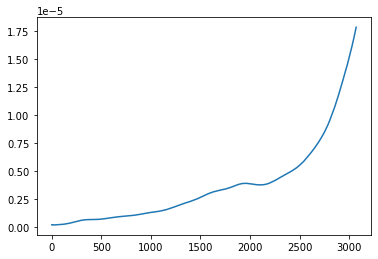

In [12]:
ell_noise = nlkk.T[0]
noise = nlkk.T[1]
plt.plot(ell_noise[:3072], noise[:3072])

In [13]:
alm_noise1 = hp.synalm(noise, lmax = 3000)
map_noise1 = hp.alm2map(alm_noise1, 4096)

maps['1'] = mapfile+map_noise1

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v1/envs/desc/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [14]:
alm_noise2 = hp.synalm(noise, lmax = 3000)
map_noise2 = hp.alm2map(alm_noise2, 4096)

maps['2'] = mapfile+map_noise2

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [15]:
alm_noise3 = hp.synalm(noise, lmax = 3000)
map_noise3 = hp.alm2map(alm_noise3, 4096)

maps['3'] = mapfile+map_noise3

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


## Treecorr Measurement Without Noise

In [16]:
measurement0 = get_measurement(0.40,0.70,'0')

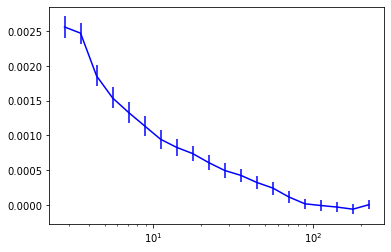

In [17]:
plt.errorbar(60*measurement0['R'],measurement0['nk']['xi'],yerr=np.sqrt(np.diag(measurement0['nk']['cov'])),color='blue')
plt.xscale('log')

## Treecorr Measurement With Noise

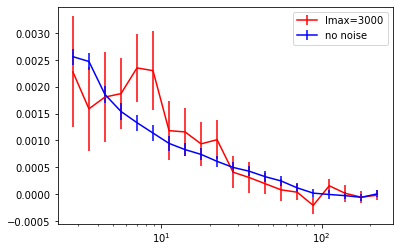

In [18]:
measurement1 = get_measurement(0.40, 0.70,'1')
plt.errorbar(60*measurement1['R'],measurement1['nk']['xi'],yerr=np.sqrt(np.diag(measurement1['nk']['cov'])),label='lmax=3000',color='red')
plt.errorbar(60*measurement0['R'],measurement0['nk']['xi'],yerr=np.sqrt(np.diag(measurement0['nk']['cov'])),label='no noise',color='blue')
plt.xscale('log')
plt.legend()

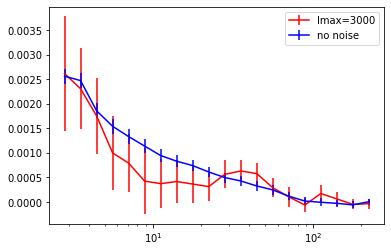

In [19]:
measurement2 = get_measurement(0.40, 0.70,'2')
plt.errorbar(60*measurement2['R'],measurement2['nk']['xi'],yerr=np.sqrt(np.diag(measurement2['nk']['cov'])),label='lmax=3000',color='red')
plt.errorbar(60*measurement0['R'],measurement0['nk']['xi'],yerr=np.sqrt(np.diag(measurement0['nk']['cov'])),label='no noise',color='blue')
plt.xscale('log')
plt.legend()

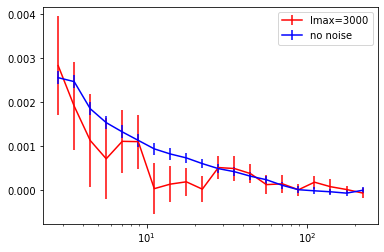

In [20]:
measurement3 = get_measurement(0.40, 0.70,'3')
plt.errorbar(60*measurement3['R'],measurement3['nk']['xi'],yerr=np.sqrt(np.diag(measurement3['nk']['cov'])),label='lmax=3000',color='red')
plt.errorbar(60*measurement0['R'],measurement0['nk']['xi'],yerr=np.sqrt(np.diag(measurement0['nk']['cov'])),label='no noise',color='blue')
plt.xscale('log')
plt.legend()